In [3]:
from pathlib import Path
path_folder = Path("/Users/keithlowton/Desktop/Ks/Training/Python_notebooks/Time Series")
print(path_folder.exists())
print(path_folder)


True
/Users/keithlowton/Desktop/Ks/Training/Python_notebooks/Time Series


In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Embedding, Input, Reshape
import matplotlib.pyplot as plt

%matplotlib inline

### Read the data in

In [12]:
TARGET = "item_price"

In [6]:
data = pd.read_csv(os.path.join(path_folder, "sales_train.csv"), sep=",")
print(data.shape)
data.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
data.duplicated().sum()

6

In [8]:
data = data.drop_duplicates()
print(data.shape)
# (2935843, 6)

(2935843, 6)


In [10]:
nonvar_lst = []

for i in range(data.shape[1]):
    print("Column: ", data.columns[i], ", number of unique classes: ", data.iloc[:,i].nunique())
    if data.iloc[:,i].nunique() < 50:
        print("Values: ", list(set(data.iloc[:,i])))
    if data.iloc[:,i].nunique() == 1:
        nonvar_lst.append(data.columns[i])

print(nonvar_lst)

Column:  date , number of unique classes:  1034
Column:  date_block_num , number of unique classes:  34
Values:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Column:  shop_id , number of unique classes:  60
Column:  item_id , number of unique classes:  21807
Column:  item_price , number of unique classes:  19993
Column:  item_cnt_day , number of unique classes:  198
[]


### Missing data

In [11]:
check = data.isnull().sum()
check = pd.DataFrame(check)
check.columns = ["Count"]
check["perc"] = check.Count/data.shape[0]*100
check

,Count,perc
date,0,0.0
date_block_num,0,0.0
shop_id,0,0.0
item_id,0,0.0
item_price,0,0.0
item_cnt_day,0,0.0


In [16]:
df = data.copy()

### Test/train split

In [64]:
y = df[TARGET]
X = df.drop([TARGET, "date"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=222)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=222)

print(X_train.shape, X_test.shape, X_val.shape)
# (2055090, 5) (880753, 5)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

X_train_orig = X_train.copy()

(1438563, 4) (880753, 4) (616527, 4)


In [22]:
X_train.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,1,28,22134,1.0
1,12,26,10487,1.0
2,10,31,9174,1.0
3,0,0,17452,1.0
4,0,56,14079,2.0


In [ ]:
def build_basic_model():
    # Specify the number of different elements in the categorical feature and
    # the length of the embedding vector these elements are going to be converted to.
    # This information is required when defining an embedding layer.
    elements_in_category = 10
    embedding_size = int(min(elements_in_category / 2, 50))

    # create an input for the categorical feature
    categorical_input = Input(shape=(1,))

    # create an input for the remaining numerical data
    numerical_input = Input(shape=(9,))

    # crate an embedding layer for the categorical feature
    category_embedding = Embedding(elements_in_category, embedding_size, input_length=1)(categorical_input)
    category_embedding = Reshape(target_shape=(embedding_size,))(category_embedding)

    # concatenate the embedding values from the categorical input
    # and the numerical inputs together
    inputs = Concatenate(axis=-1)([category_embedding, numerical_input])

    # create a basic 100 node MLP with a single node regression output
    dense_layer = Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.01))(inputs)
    output_layer = Dense(1, kernel_regularizer=regularizers.l2(0.01))(dense_layer)

    # build the model
    model = keras.Model(inputs=[categorical_input, numerical_input], outputs=output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])

    return model


In [102]:
cat_features = [
    "date_block_num",
    "item_id",
    "shop_id"
]

train_val_cat_features = pd.concat([X_train[cat_features], X_val[cat_features]])

enc = OrdinalEncoder().fit(train_val_cat_features)

train_data_cat_features = pd.DataFrame(enc.transform(X_train[cat_features]), columns=cat_features)
val_data_cat_features = pd.DataFrame(enc.transform(X_val[cat_features]), columns=cat_features)


In [106]:
    # inputs to model need to come in the form of a list containing a (1,n) vector
    # for each categorical variable in order, and a (n, n_continuous_features) matrix
    # of the remaining continuous features
    X_train_nn = []
    X_val_nn = []
    X_test_nn = []

    # this loops over the categorical features and creates an individual vector for
    # each one, appending it to the input list
    for cat in cat_features:
        X_train_nn.append(np.array(train_data_cat_features[cat]).reshape(-1, 1))
        X_val_nn.append(np.array(val_data_cat_features[cat]).reshape(-1,1))
        #X_test_nn.append(np.array(test_data_cat_features[cat]).reshape(-1,1))

    X_train_nn.append(X_train.drop(cat_features, axis=1).values)
    X_val_nn.append(X_val.drop(cat_features, axis=1).values)
    #X_test_nn.append(X_test.drop(cat_features, axis=1).values)

In [144]:
def build_categorical_inputs(features):

    initial_inputs = {}
    cat_input_layers = {}

    for feature in features:
        no_of_unique_cats = train_val_cat_features[feature].nunique()
        embedding_size = int(min(np.ceil((no_of_unique_cats) / 2), 50))
        categories = no_of_unique_cats
        print(feature, no_of_unique_cats, embedding_size)

        initial_inputs[feature] = Input(shape=(1,))
        embedding_layer = Embedding(
            categories, embedding_size, embeddings_regularizer=regularizers.l2(0.01), input_length=1
        )(initial_inputs[feature])
        cat_input_layers[feature] = Reshape(target_shape=(embedding_size,))(embedding_layer)

    return initial_inputs, cat_input_layers


In [145]:
initial_inputs, input_layers = build_categorical_inputs(cat_features)

date_block_num 34 17
item_id 20999 50
shop_id 60 30


In [126]:
def build_model():

    initial_inputs, input_layers = build_categorical_inputs(cat_features)

    no_of_num_features = len(X_train.columns) - len(cat_features)

    initial_inputs["numerical_features"] = Input(shape=(no_of_num_features,))
    input_layers["numerical_features"] = initial_inputs["numerical_features"]

    inputs = Concatenate(axis=-1)([layer for layer in input_layers.values()])

    drop_1_out = Dropout(0.1)(inputs)
    dense_1_out = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(drop_1_out)
    drop_2_out = Dropout(0.1)(dense_1_out)
    dense_2_out = Dense(125, activation="relu", kernel_regularizer=regularizers.l2(0.01))(drop_2_out)
    drop_3_out = Dropout(0.1)(dense_2_out)
    dense_3_out = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(drop_3_out)
    drop_4_out = Dropout(0.1)(dense_3_out)
    dense_4_out = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01))(drop_4_out)
    final_out = Dense(1, kernel_regularizer=regularizers.l2(0.01))(dense_4_out)

    model = keras.Model(inputs=[input for input in initial_inputs.values()], outputs=final_out)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])

    return model


model = build_model()


In [127]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_27 (Embedding)       (None, 1, 17)        578         ['input_31[0][0]']               
                                                                                            

In [128]:
checkpoint_path = os.getcwd()
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

# create an early stopping callback
# will stop training if the validation MSE hasn't improved in (patience) epochs
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# train the model
history = model.fit(
    X_train_nn,
    y_train,
    batch_size=1000,
    epochs=3,
    validation_data=(X_val_nn, y_val),
    callbacks=[checkpoint, early_stop],
    verbose=1,
)


Epoch 1/3
1438/1439 [============================>.] - ETA: 0s - loss: 3803948.0000 - mae: 887.8030 - mse: 3803936.5000
Epoch 1: saving model to /Users/keithlowton/Documents/Repository/Exploration/Embeddings
1439/1439 [==============================] - 50s 33ms/step - loss: 3803998.5000 - mae: 887.8167 - mse: 3803987.2500 - val_loss: 3700718.5000 - val_mae: 883.8286 - val_mse: 3700708.7500
Epoch 2/3
1439/1439 [==============================] - ETA: 0s - loss: 3721984.0000 - mae: 843.3570 - mse: 3721974.2500
Epoch 2: saving model to /Users/keithlowton/Documents/Repository/Exploration/Embeddings
1439/1439 [==============================] - 50s 34ms/step - loss: 3721984.0000 - mae: 843.3570 - mse: 3721974.2500 - val_loss: 3484855.5000 - val_mae: 764.5989 - val_mse: 3484842.7500
Epoch 3/3
1438/1439 [============================>.] - ETA: 0s - loss: 3319755.2500 - mae: 665.1226 - mse: 3319743.7500
Epoch 3: saving model to /Users/keithlowton/Documents/Repository/Exploration/Embeddings
1439/1

In [129]:
shop_id_weights = model.get_weights()[2]
item_id_weights = model.get_weights()[1]
date_block_num_weights = model.get_weights()[0]

In [130]:
print(shop_id_weights.shape, item_id_weights.shape, date_block_num_weights.shape)

(60, 30) (20999, 50) (34, 17)


In [146]:
shop_ids = train_val_cat_features["shop_id"].unique()
shop_id_col = ["shop_id_" + str(i) for i in range(int(min(np.ceil((len(shop_ids)) / 2), 50)))]

item_ids = train_val_cat_features["item_id"].unique()
item_id_col = ["item_id_" + str(i) for i in range(int(min(np.ceil((len(item_ids)) / 2), 50)))]
print(len(shop_ids), len(item_ids))

print(len(shop_id_col), len(item_id_col))

shop_id_df = pd.DataFrame(index=shop_ids, columns=shop_id_col, data=shop_id_weights)
item_id_df = pd.DataFrame(columns=item_id_col, index=item_ids, data=item_id_weights)
print(shop_id_df.shape, item_id_df.shape)


60 20999
30 50
(60, 30) (20999, 50)


In [147]:
shop_id_df.head()

,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_8,shop_id_9,...,shop_id_20,shop_id_21,shop_id_22,shop_id_23,shop_id_24,shop_id_25,shop_id_26,shop_id_27,shop_id_28,shop_id_29
57.0,-0.044349,-0.002245,0.007406,-0.082218,-0.070180,0.043989,0.031000,0.073074,0.059507,0.049253,...,0.010976,0.073929,0.058995,-0.039650,0.071175,0.001349,0.083230,0.042566,0.085323,-0.009586
50.0,-0.063639,-0.025872,-0.060556,-0.039617,0.004974,0.056524,0.002098,0.065736,0.055348,0.048866,...,-0.024449,0.036714,0.052793,-0.048324,0.042200,0.066766,-0.014437,0.041817,0.014052,-0.062697
31.0,-0.037976,-0.089437,-0.030920,-0.102005,-0.019204,0.038500,0.103557,0.041750,0.055626,0.101809,...,-0.029935,0.093043,0.107268,-0.012476,0.027424,0.023783,0.023465,0.080800,0.064675,-0.074927
37.0,-0.029714,-0.020906,-0.041865,-0.068793,-0.108407,0.019404,0.015790,0.060260,0.057209,0.104842,...,-0.081809,0.020167,0.055709,-0.072724,0.020763,0.085190,0.080583,0.074131,0.105926,-0.067276
25.0,-0.017075,-0.105968,-0.046713,-0.088426,-0.099309,0.058252,0.021143,0.015360,0.097361,0.022454,...,-0.041432,0.024234,0.103272,-0.017656,0.029855,0.094106,0.034966,0.064289,0.055228,-0.093625


In [78]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,3.804255e+06,887.944702,3.804241e+06,3.702206e+06,884.578369,3.702196e+06,0
1,3.731088e+06,848.342590,3.731077e+06,3.506811e+06,776.856750,3.506798e+06,1
2,3.356632e+06,674.148499,3.356618e+06,3.003100e+06,623.273987,3.003086e+06,2
3,2.981776e+06,648.542053,2.981762e+06,2.763426e+06,665.027283,2.763412e+06,3
4,2.817661e+06,662.218628,2.817647e+06,2.619023e+06,642.577271,2.619008e+06,4
5,2.663190e+06,616.611694,2.663177e+06,2.452262e+06,577.572876,2.452244e+06,5
6,2.479972e+06,540.361267,2.479954e+06,2.257358e+06,494.333038,2.257341e+06,6
7,2.293905e+06,458.749786,2.293886e+06,2.061914e+06,413.298920,2.061895e+06,7
8,2.105847e+06,397.611725,2.105828e+06,1.880132e+06,365.342224,1.880112e+06,8
9,1.924589e+06,362.625214,1.924568e+06,1.698096e+06,338.567383,1.698076e+06,9


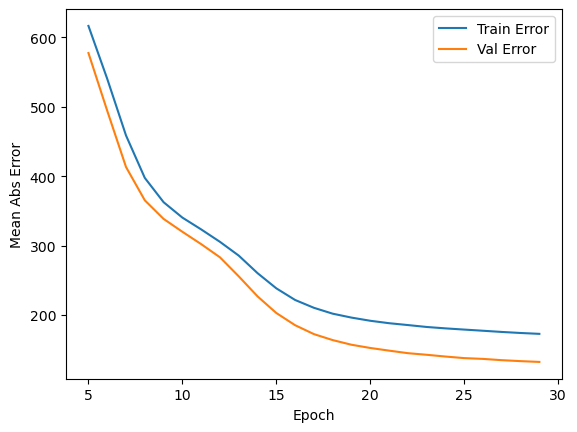

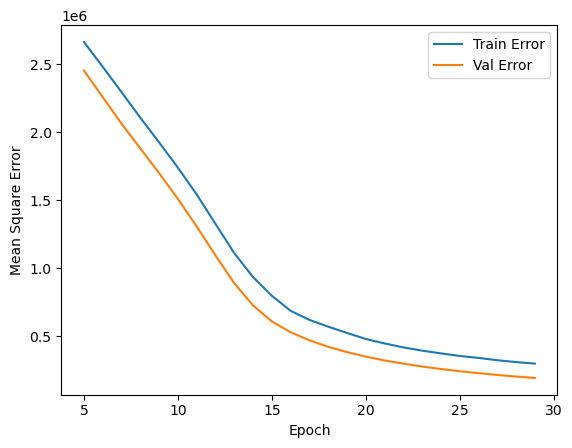

In [79]:
def plot_history(hist):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error")
    plt.plot(hist["epoch"], hist["mae"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mae"], label="Val Error")
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error")
    plt.plot(hist["epoch"], hist["mse"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mse"], label="Val Error")
    plt.legend()
    plt.show()


plot_history(hist.iloc[5:])


In [77]:
model.evaluate(X_test_nn, y_test)

27524/27524 [==============================] - 110s 4ms/step - loss: 212747.8438 - mae: 133.1581 - mse: 212718.3438


[212747.84375, 133.15814208984375, 212718.34375]